In [1]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse
import seaborn as sns
from shapely.geometry import Point
import geopandas
from geodatasets import get_path
import glob

import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np



In [36]:
path_high = '~/dales/build/stable_runs/high_shear_output/'
path_low = '~/dales/build/stable_runs/low_shear_output/'

profile_high = xr.open_dataset(path_high +'profiles.001.nc')
tmser_high = xr.open_dataset(path_high +'tmser.001.nc')
profile_low = xr.open_dataset(path_low +'profiles.001.nc')
tmser_low = xr.open_dataset(path_low +'tmser.001.nc')

profile_high['time'] = profile_high['time'].astype('datetime64[s]') + np.timedelta64(6, 'h')
tmser_high['time'] = tmser_high['time'].astype('datetime64[s]') + np.timedelta64(6, 'h')
profile_low['time'] = profile_low['time'].astype('datetime64[s]') + np.timedelta64(6, 'h')
tmser_low['time'] = tmser_low['time'].astype('datetime64[s]') + np.timedelta64(6, 'h')


# tmser_high
# profile_high

In [3]:
file = 'crossyz.x000y001.001.nc'
cross_low = xr.open_dataset(path_low + file)
# cross_low

cross_high = xr.open_dataset(path_high + file)
# cross_high

In [37]:
Rd = 287 #J/kgK
cp = 1005 #J/kgK

profile_high['pressure'] = profile_high['presh']/100
profile_high['virt_T'] = profile_high['thv']/((1000/profile_high['pressure'])**(Rd/cp))
profile_high['spec_hum'] = profile_high['qt']-profile_high['ql']

profile_high['temp'] = profile_high['virt_T']/(1+0.61*profile_high['spec_hum'])

profile_high['pres'] = profile_high['pressure']*units.hPa
profile_high['temp'] = profile_high['temp']*units.K

profile_high['RH'] = mpcalc.relative_humidity_from_specific_humidity(profile_high['pres'] , profile_high['temp'], profile_high['spec_hum'])*100
mask = profile_high['RH'] < 100.00001

# Set the values to NaN where the mask is True
profile_high['supersat'] = xr.where(mask, np.nan, profile_high['RH'])



### for the low profile 

profile_low['pressure'] = profile_low['presh']/100
profile_low['virt_T'] = profile_low['thv']/((1000/profile_low['pressure'])**(Rd/cp))
profile_low['spec_hum'] = profile_low['qt']-profile_low['ql']

profile_low['temp'] = profile_low['virt_T']/(1+0.61*profile_low['spec_hum'])

profile_low['pres'] = profile_low['pressure']*units.hPa
profile_low['temp'] = profile_low['temp']*units.K

profile_low['RH'] = mpcalc.relative_humidity_from_specific_humidity(profile_low['pres'] , profile_low['temp'], profile_low['spec_hum'])*100
mask = profile_low['RH'] < 100.00001

# Set the values to NaN where the mask is True
profile_low['supersat'] = xr.where(mask, np.nan, profile_low['RH'])


In [38]:
tmser_high['lwp_bar_m'] = tmser_high['lwp_bar']*1000
tmser_low['lwp_bar_m'] = tmser_low['lwp_bar']*1000


In [39]:
min_time = tmser_low.time.min()
max_time = tmser_low.time.min() + + np.timedelta64(10000, 's')

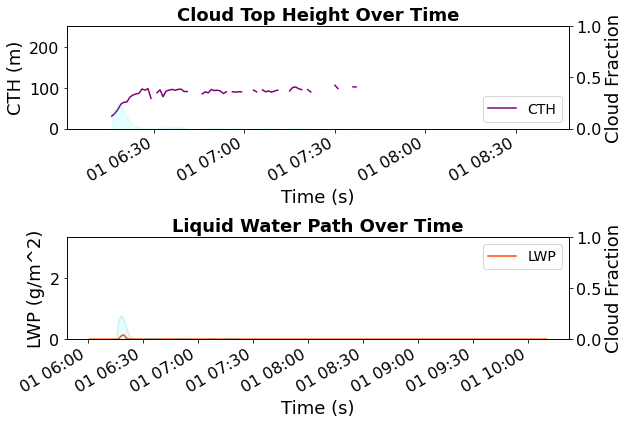

In [40]:

fig, axs = plt.subplots(nrows=2, figsize = (9, 6))

ax1 = axs[0]   # Line plot axis
ax2 = ax1.twinx()  # Bar plot axis

tmser_high.zc_av.plot(ax=ax1, color = 'purple', x = 'time')
tmser_high.cfrac.plot(ax=ax2, alpha=0.01)
ax2.fill_between(tmser_high['time'], tmser_high.cfrac, color='cyan', alpha=0.1, label='Shaded Area')



ax3 = axs[1]   # Line plot axis
ax4 = ax3.twinx()  # Bar plot axis

tmser_high.lwp_bar_m.plot(ax=ax3, color = 'orangered', x = 'time')
tmser_high.cfrac.plot(ax=ax4, alpha=0.1)
ax4.fill_between(tmser_high['time'], tmser_high.cfrac, color='cyan', alpha=0.1, label='Shaded Area')

# ax5 = axs[2]   # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis

# tmser_high.cliq.plot(ax=ax5, color = 'purple')
# tmser_high.cfrac.plot(ax=ax6, alpha=0.01)
# ax6.fill_between(tmser_high['time'], tmser_high.cfrac, color='cyan', alpha=0.1, label='Shaded Area')

# # Add a legend for each variable
ax1.legend(['CTH'], loc='lower right', fontsize=14)
# ax2.legend(['Cloud Fraction of Grid'], loc='upper right', fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('CTH (m)', fontsize=18)
ax2.set_ylabel('Cloud Fraction', fontsize=18)
ax1.set_title('Cloud Top Height Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)
ax1.set_ylim(0, float(tmser_low.zc_av.max()))
ax2.set_ylim(0, 1)

# # Add a legend for each variable
ax3.legend(['LWP'], loc='upper right', fontsize=14)
# ax2.legend(['Cloud Fraction of Grid'], loc='upper right', fontsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax4.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax3.set_xlabel('Time (s)', fontsize=18)
ax3.set_ylabel('LWP (g/m^2)', fontsize=18)
ax4.set_ylabel('Cloud Fraction', fontsize=18)
ax3.set_title('Liquid Water Path Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)
ax3.set_ylim(0, float(tmser_low.lwp_bar_m.max()))
ax4.set_ylim(0, 1)

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()

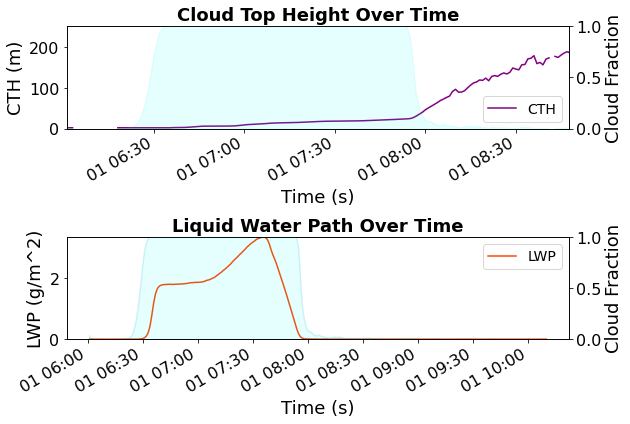

In [41]:

fig, axs = plt.subplots(nrows=2, figsize = (9, 6))

ax1 = axs[0]   # Line plot axis
ax2 = ax1.twinx()  # Bar plot axis

tmser_low.zc_av.plot(ax=ax1, color = 'purple', x = 'time')
tmser_low.cfrac.plot(ax=ax2, alpha=0.01)
ax2.fill_between(tmser_low['time'], tmser_low.cfrac, color='cyan', alpha=0.1, label='Shaded Area')



ax3 = axs[1]   # Line plot axis
ax4 = ax3.twinx()  # Bar plot axis

tmser_low.lwp_bar_m.plot(ax=ax3, color = 'orangered', x = 'time')
tmser_low.cfrac.plot(ax=ax4, alpha=0.1)
ax4.fill_between(tmser_low['time'], tmser_low.cfrac, color='cyan', alpha=0.1, label='Shaded Area')

# ax5 = axs[2]   # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis

# tmser_low.cliq.plot(ax=ax5, color = 'purple')
# tmser_low.cfrac.plot(ax=ax6, alpha=0.01)
# ax6.fill_between(tmser_low['time'], tmser_low.cfrac, color='cyan', alpha=0.1, label='Shaded Area')

# # Add a legend for each variable
ax1.legend(['CTH'], loc='lower right', fontsize=14)
# ax2.legend(['Cloud Fraction of Grid'], loc='upper right', fontsize=16)
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('CTH (m)', fontsize=18)
ax2.set_ylabel('Cloud Fraction', fontsize=18)
ax1.set_title('Cloud Top Height Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)
ax1.set_ylim(0, float(tmser_low.zc_av.max()))
ax2.set_ylim(0, 1)

# # Add a legend for each variable
ax3.legend(['LWP'], loc='upper right', fontsize=14)
# ax2.legend(['Cloud Fraction of Grid'], loc='upper right', fontsize=16)
ax3.tick_params(axis='both', labelsize=16)
ax4.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax3.set_xlabel('Time (s)', fontsize=18)
ax3.set_ylabel('LWP (g/m^2)', fontsize=18)
ax4.set_ylabel('Cloud Fraction', fontsize=18)
ax3.set_title('Liquid Water Path Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)
ax3.set_ylim(0, float(tmser_low.lwp_bar_m.max()))
ax4.set_ylim(0, 1)

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()

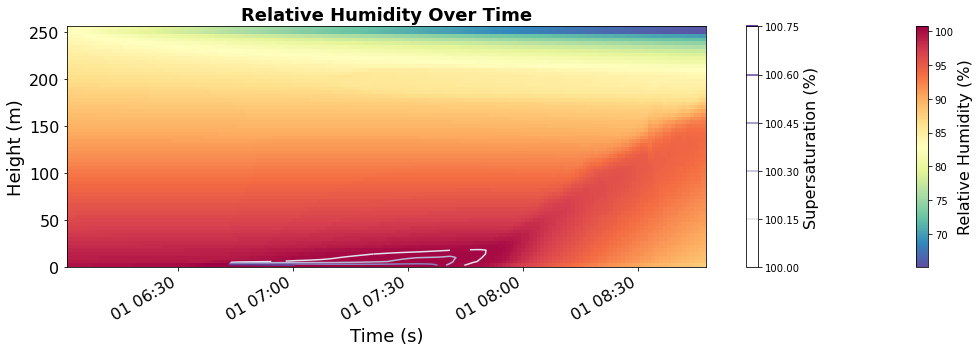

In [42]:
fig, axs = plt.subplots(nrows=1, figsize = (15, 5))
ax1 = axs  # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis

plot1 = profile_low.RH.plot.pcolormesh(
    ax = ax1,
        # ax=axes[i, 0],
        # vmin=-30,
        # vmax=30,
            # vmax=3,
        cmap="Spectral_r"
      ,  add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )
cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical')
cbar1.set_label('Relative Humidity (%)', fontsize=16)
plot2 = profile_low.supersat.plot.contour(
    ax = ax1,
        # ax=axes[i, 0],
        # vmin=-30,
        # vmax=30,
            # vmax=3,
        cmap="Purples"
            # ,add_colorbar=True
        # extend="both",
    , x='time'
    ,y='zt'
    )
# ax5.set_xlim(0, 10000)
cbar2 = plt.colorbar(plot2, ax=ax1, orientation='vertical')
cbar2.set_label('Supersaturation (%)', fontsize=16)

# ax1.legend(['CTH'], loc='lower right', fontsize=14)
ax1.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('Height (m)', fontsize=18)
ax1.set_title('Relative Humidity Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)


plt.tight_layout()

# Display the plot
plt.show()

In [25]:
# profile_high.u.plot.contour(
#      x='time'
#     ,y='zt')

In [24]:
# profile_low.u.plot.contour(
#      x='time'
#     ,y='zt')

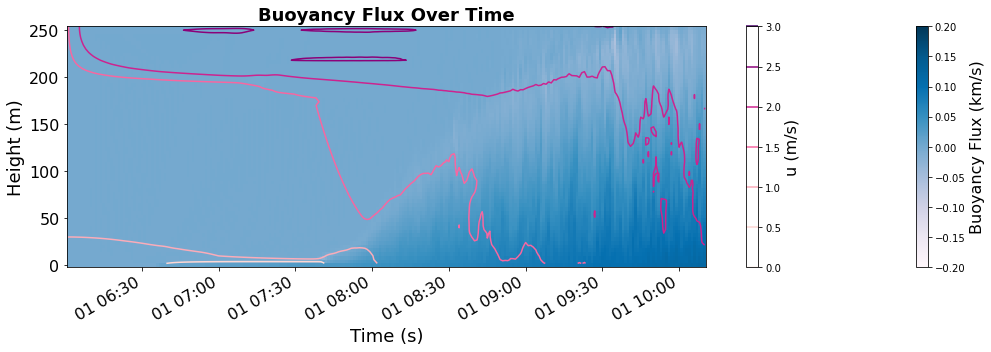

In [43]:
fig, axs = plt.subplots(nrows=1, figsize = (15, 5))
ax2 = axs 
# ax6 = ax5.twinx()  # Bar plot axis

plot3 = profile_low.wthvt.plot.pcolormesh(
    ax = ax2,
        # ax=axes[i, 0],
        vmin=-0.2,
        vmax=.2,
            # vmax=3,
        cmap="PuBu",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zm'
    )


plot1 = profile_low.u.plot.contour(
    ax = ax2,
        # ax=axes[i, 0],
        # vmin=100,
        # vmax=int(profile_high.u.max()),
            # vmax=3,
        cmap="RdPu",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )


cbar2 = plt.colorbar(plot3, ax=ax2, orientation='vertical')
cbar2.set_label('Buoyancy Flux (km/s)', fontsize=16)

cbar2 = plt.colorbar(plot1, ax=ax2, orientation='vertical')
cbar2.set_label('u (m/s)', fontsize=16)
# ax1.legend(['CTH'], loc='lower right', fontsize=14)
ax2.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax2.set_xlabel('Time (s)', fontsize=18)
ax2.set_ylabel('Height (m)', fontsize=18)
ax2.set_title('Buoyancy Flux Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(min_time, max_time)


plt.tight_layout()

# Display the plot
plt.show()

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


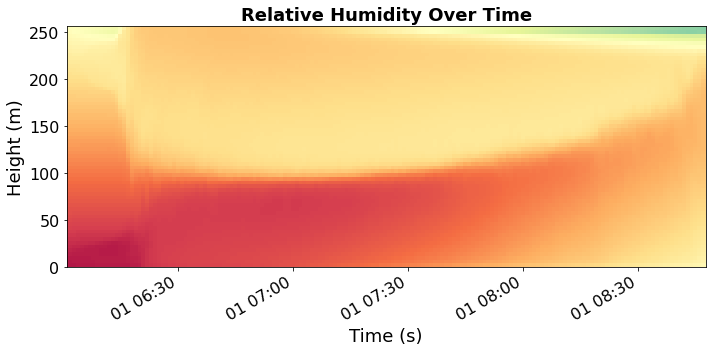

In [44]:
fig, axs = plt.subplots(nrows=1, figsize = (10, 5))
ax1 = axs  # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis
plot1 = profile_high.RH.plot.pcolormesh(
    ax = ax1,
        # ax=axes[i, 0],
        vmin=float(profile_low.RH.min()),
        vmax=float(profile_low.RH.max()),
            # vmax=3,
        cmap="Spectral_r",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )

plot1 = profile_high.supersat.plot.contour(
    ax = ax1,
        # ax=axes[i, 0],
        vmin=100,
        vmax=100.75,
            # vmax=3,
        cmap="Purples",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )

# ax1.legend(['CTH'], loc='lower right', fontsize=14)
ax1.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('Height (m)', fontsize=18)
ax1.set_title('Relative Humidity Over Time', fontsize=18, fontweight='bold')
# ax1.set_xlim(0, 10000)
ax1.set_xlim(min_time, max_time)


plt.tight_layout()

# Display the plot
plt.show()

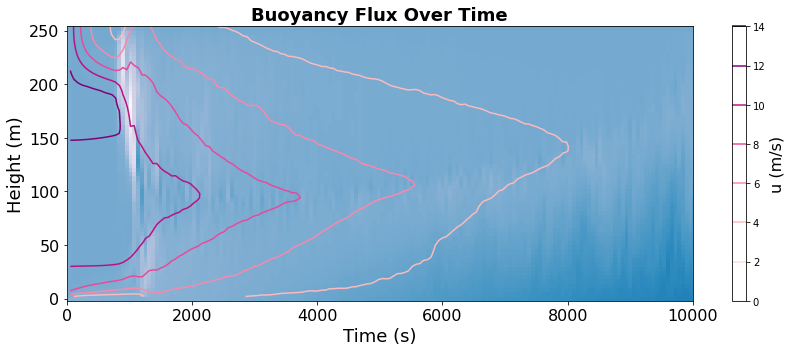

In [104]:
fig, axs = plt.subplots(nrows=1, figsize = (12, 5))
ax2 = axs 
# ax6 = ax5.twinx()  # Bar plot axis

plot3 = profile_high.wthvt.plot.pcolormesh(
    ax = ax2,
        # ax=axes[i, 0],
        # vmin=-30,
        # vmax=30,
            # vmax=3,
        cmap="PuBu",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zm'
    )

plot1 = profile_high.u.plot.contour(
    ax = ax2,
        # ax=axes[i, 0],
        # vmin=100,
        # vmax=100.75,
            # vmax=3,
        cmap="RdPu",
        add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )


# cbar2 = plt.colorbar(plot3, ax=ax2, orientation='vertical')
# cbar2.set_label('Buoyancy Flux (km/s)', fontsize=16)

cbar2 = plt.colorbar(plot1, ax=ax2, orientation='vertical')
cbar2.set_label('u (m/s)', fontsize=16)

# cbar2 = plt.colorbar(plot3, ax=ax2, orientation='vertical')
# cbar2.set_label('Buoyancy Flux (km/s)', fontsize=16)
# ax1.legend(['CTH'], loc='lower right', fontsize=14)
ax2.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax2.set_xlabel('Time (s)', fontsize=18)
ax2.set_ylabel('Height (m)', fontsize=18)
ax2.set_title('Buoyancy Flux Over Time', fontsize=18, fontweight='bold')
ax2.set_xlim(0, 10000)


plt.tight_layout()

# Display the plot
plt.show()

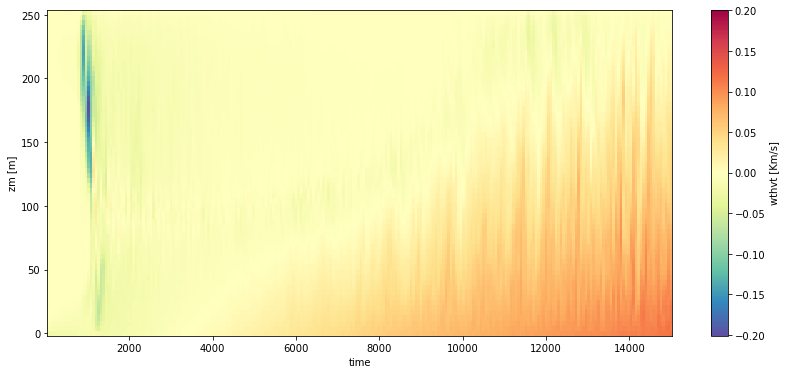

In [41]:
fig, axs = plt.subplots(nrows=1, figsize = (15, 5))
ax1 = axs  # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis

plot1 = profile_low.RH.plot.pcolormesh(
    ax = ax1,
        # ax=axes[i, 0],
        # vmin=-30,
        # vmax=30,
            # vmax=3,
        cmap="Spectral_r"
      ,  add_colorbar=False
        # extend="both",
    , x='time'
    ,y='zt'
    )
cbar1 = plt.colorbar(plot1, ax=ax1, orientation='vertical')
cbar1.set_label('Relative Humidity (%)', fontsize=16)
plot2 = profile_low.supersat.plot.contour(
    ax = ax1,
        # ax=axes[i, 0],
        # vmin=-30,
        # vmax=30,
            # vmax=3,
        cmap="Purples"
            # ,add_colorbar=True
        # extend="both",
    , x='time'
    ,y='zt'
    )
# ax5.set_xlim(0, 10000)
cbar2 = plt.colorbar(plot2, ax=ax1, orientation='vertical')
cbar2.set_label('Supersaturation (%)', fontsize=16)

# ax1.legend(['CTH'], loc='lower right', fontsize=14)
ax1.tick_params(axis='both', labelsize=16)
# # Set common x-label for the entire subplot
ax1.set_xlabel('Time (s)', fontsize=18)
ax1.set_ylabel('Height (m)', fontsize=18)
ax1.set_title('Relative Humidity Over Time', fontsize=18, fontweight='bold')
ax1.set_xlim(0, 10000)


plt.tight_layout()

# Display the plot
plt.show()

In [30]:
float(profile_low.RH.min())

65.09120178222656

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


(0.0, 15000.0)

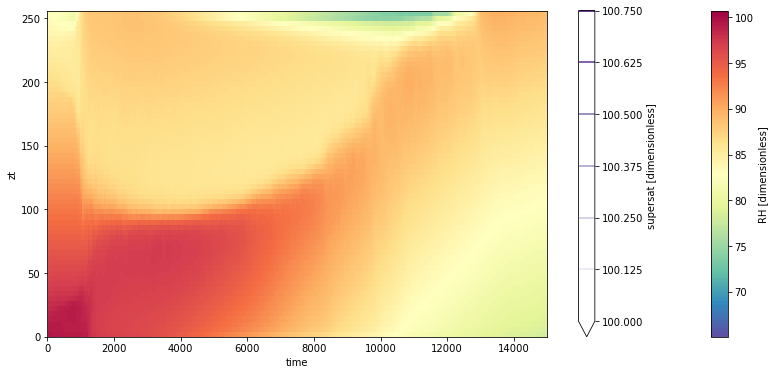

In [33]:
fig, axs = plt.subplots(nrows=1, figsize = (14, 12))
ax1 = axs  # Line plot axis
# ax6 = ax5.twinx()  # Bar plot axis

plot1 = profile_high.RH.plot.pcolormesh(
    ax = ax1,
        # ax=axes[i, 0],
        vmin=float(profile_low.RH.min()),
        vmax=float(profile_low.RH.max()),
            # vmax=3,
        cmap="Spectral_r",
        add_colorbar=True
        # extend="both",
    , x='time'
    ,y='zt'
    )

plot1 = profile_high.supersat.plot.contour(
    ax = ax1,
        # ax=axes[i, 0],
        vmin=100,
        vmax=100.75,
            # vmax=3,
        cmap="Purples",
        add_colorbar=True
        # extend="both",
    , x='time'
    ,y='zt'
    )
ax5.set_xlim(0, 15000)



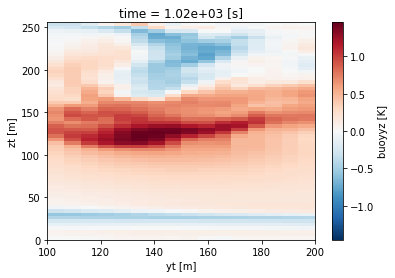

In [157]:
cross.sel(time = [1000], method="nearest").buoyyz.plot()

TypeError: 'Axes' object is not iterable

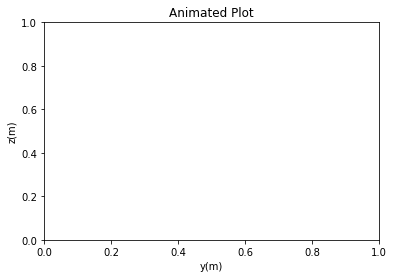

In [154]:
fig, ax = plt.subplots()
# Define the initialization function
def init():
    ax.set_xlabel('y(m)')
    ax.set_ylabel('z(m)')
    ax.set_title('Animated Plot')
    return ax

# Define the update function
def update(frame):
    ax.cla()  # Clear the axis for the new frame
    cross.buoyyz[frame].plot(ax=ax, cmap='viridis', add_colorbar=False)
    plt.colorbar(mappable=ax.images[-1], ax=ax)
    ax.set_xlabel('y(m)')
    ax.set_ylabel('z(m)')
    ax.set_title(f'Time = {data.time[frame]}')
    return ax

# Create the animation
anim = FuncAnimation(fig, update, frames=cross.time.size, init_func=init, blit=True)

# Display the animation
plt.show()


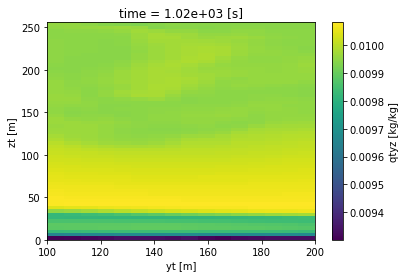

In [146]:
cross.sel(time = [1000], method="nearest").qtyz.plot()

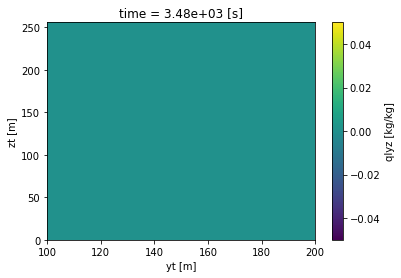

In [145]:
cross.sel(time = [3500], method="nearest").qlyz.plot()

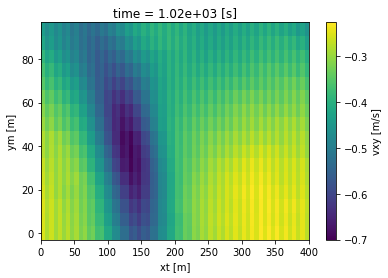

In [140]:
cross.sel(time = [1000], method="nearest").vxy.plot()

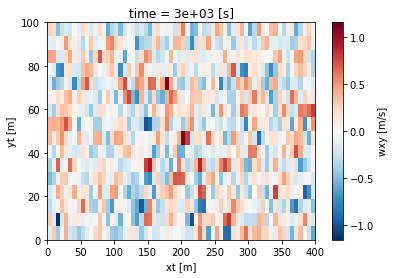

In [137]:
cross.sel(time = [3000], method="nearest").wxy.plot()

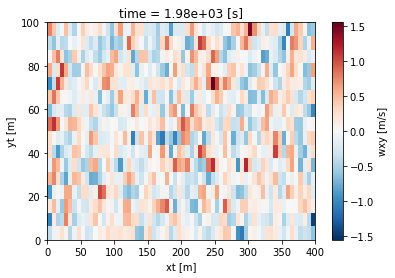

In [138]:
cross.sel(time = [2000], method="nearest").wxy.plot()

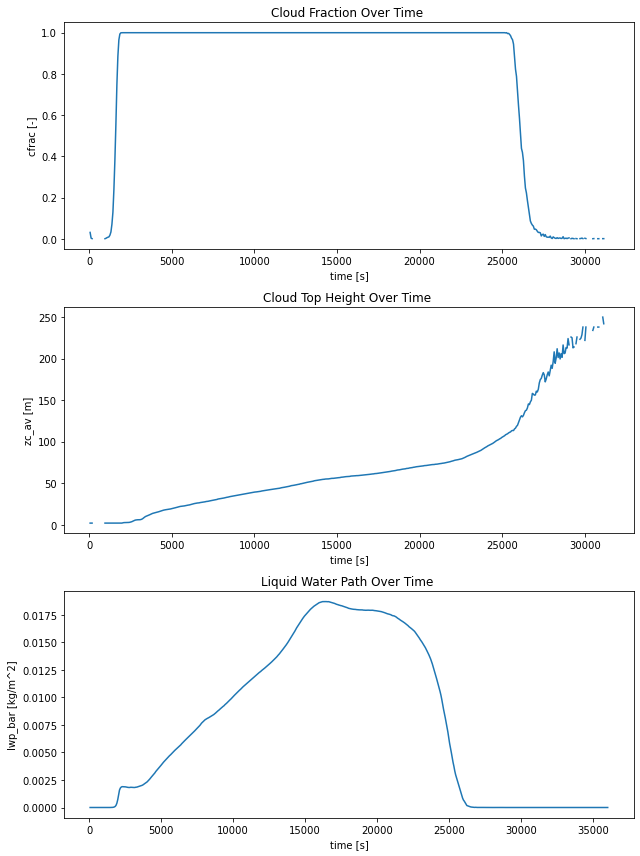

In [38]:
fig, axs = plt.subplots(nrows=3, figsize = (9, 12))
plot1 = tmser.cfrac.plot(ax=axs[0])
plot2 = tmser.zc_av.plot(ax=axs[1])
plot3 = tmser.lwp_bar.plot(ax=axs[2])

plt.tight_layout()
axs[0].set_title('Cloud Fraction Over Time ')
axs[1].set_title('Cloud Top Height Over Time ')
axs[2].set_title('Liquid Water Path Over Time ')
# axs[3].set_title('Liquid Water Path Over Time ')
plt.tight_layout()
plt.show()

<xarray.DataArray 'cfrac' (time: 600)>
array([0.030762, 0.00293 , 0.000488, ...,      nan,      nan,      nan],
      dtype=float32)
Coordinates:
  * time     (time) float32 60.0 120.0 180.0 ... 3.588e+04 3.594e+04 3.6e+04
Attributes:
    longname:  Cloud fraction
    units:     -